In [2]:
import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt

!git clone https://github.com/Amogh13246831/Handwriting-GAN
!ls

Cloning into 'Handwriting-GAN'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.
Handwriting-GAN  sample_data


In [0]:
def generate_latent_noise(latent_dim, n_samples, n_classes=47):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

In [4]:
gen = load_model('Handwriting-GAN/models/generator.h5')

latent_dim = gen.input[0].shape[1]
print('\n', 'Latent space dimension:', latent_dim, '\n')
gen.summary()


 Latent space dimension: 100 

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 6272)         633472      input_20[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        2350        input_19[0][0]                   
___________________________________________________________

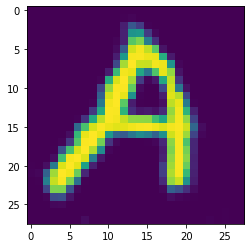

In [11]:
X, _ = generate_latent_noise(latent_dim, 1)
label = np.asarray([10])

out = gen.predict([X, label])
out = np.squeeze(out)
plt.imshow(out)

EMNIST Balanced dataset encoding:
 {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a': 36, 'b': 37, 'c': 12, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 43, 'o': 24, 'p': 25, 'q': 44, 'r': 45, 's': 28, 't': 46, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35} 



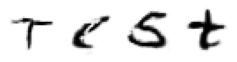

In [9]:
def get_emnist_balanced_dict():
  balanced_dict = {chr(i): i-48 for i in range(48, 58)}
  balanced_dict.update({chr(i): i-55 for i in range(65, 91)})
  balanced_dict.update({'a':36, 'b':37, 'c':12, 'd':38, 'e':39, 'f':40, 'g':41,
                        'h':42, 'i':18, 'j':19, 'k':20, 'l':21, 'm':22, 'n':43,
                        'o':24, 'p':25, 'q':44, 'r':45, 's':28, 't':46, 'u':30,
                        'v':31, 'w':32, 'x':33, 'y':34, 'z':35})
  return balanced_dict

def generate_word_images(word, latent_dim, label_dict):
  labels = np.asarray([label_dict[ch] for ch in word])
  noise, _ = generate_latent_noise(latent_dim, len(word))
  images = np.squeeze(gen.predict([noise, labels]))
  return images

balanced_dict = get_emnist_balanced_dict()
print('EMNIST Balanced dataset encoding:\n', balanced_dict, '\n')

images = generate_word_images('Test', 100, balanced_dict)
images = (images + 1) / 2.0

def show_generated(examples, n, c):
  fig = plt.figure(figsize=(c, n))
  for i in range(n*c):
    img = fig.add_subplot(n, c, i+1)
    plt.axis('off')
    plt.imshow(examples[i,:], cmap='gray_r')
  plt.show()

show_generated(images, 1, len(images))